In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import nltk
from konlpy.tag import Okt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans as km

import hdbscan
from sklearn.cluster import DBSCAN


# 한글 폰트 설정
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~')

### Stemming & tokenizing & Word2vec

In [4]:
path = "../../datas/"
stopwords = ['',' ', '지다', ' ', '아', '나', '정', '다','좀', '있다', '조금', '요', '되어다', '더', '너', '친', '가자', '아주', '그렇다', '바라','싶다','습니다','좀',
             '및', '...', '도', '수', '나다', '엄청', '것', '점', '등', '사', '에', '옆','이다','보다', '되다', '항상', '어요']
data = pd.read_csv(path+"v5_category_re_token_sum.csv")
reviews = data['highlight_review']

new_list = []
for r in range(len(data)):
    try: 
        rv = reviews.iloc[r]
        rv = rv.split(" ")
        rv.append(data['category'].iloc[r])
        rv = [re.compile('[^가-힣]+').sub("", r) for r in rv]
        rv = [re.compile('[은, 는, 이, 도, 들, 의]+').sub("", r) for r in rv]
        rv = [r.replace(r, "") if len(r)<1 or r in stopwords else r for r in rv]
        new_list.append(rv)

    except:
        new_list.append("")

# vocabs = [word for word in new_list if word not in stopwords and len(word)>1]
print("total words num: ", len(new_list))
data['cat_plus_rv'] = new_list
reviews = data['cat_plus_rv']
model = Word2Vec(reviews, sg=1, # skinp-gram: 중심단어로 주변단어 예측
                 vector_size=2,
                 workers=6, 
                 window=5,      # 중심 단어로부터 좌우 n개까지 학습에 적용
                 min_count=100, # 전체 문서에서 최소 n회 이상 출현 단어로 학습
                 sample=0.001
                ) 

word_vectors = model.wv.vectors

vocabs = list(model.wv.index_to_key)
word_vectors_list = [model.wv[v] for v in vocabs]

print(len(word_vectors), len(vocabs), vocabs)

total words num:  120997
366 366 ['좋다', '메인시설', '서비스', '', '친절하다', '만족', '사장님', '너무', '깨끗하다', '분위기', '시설', '청결', '부대공용시설', '전망', '위치', '화장실', '수영장', '자다', '깔끔하다', '정말', '많다', '가격', '계곡', '만족하다', '하다', '직원분', '없다', '뷰', '샤워실', '개수대', '넘다', '가깝다', '모두', '샤워장', '경치', '넓다', '오다', '괜찮다', '아쉽다', '조용하다', '방', '음식조식', '매우', '비품', '따뜻하다', '가다', '관리', '편하다', '친절', '너무좋다', '않다', '만족스럽다', '관리가', '글램핑', '뷰가', '캠핑장', '풍경', '또', '주변', '너무너무', '불편하다', '진짜', '내부', '놀다', '잘되어다', '편시설', '벌레', '사장님께서', '예쁘다', '사트', '주인분', '청결하다', '물', '같다', '온수', '최고다', '카라반', '고', '쁘다', '쉬다', '나무', '많', '바베큐', '벌레가', '최고', '매점', '바로', '좋아하다', '생각보다', '완전', '나오다', '분위기가', '크다', '멀다', '안되다', '경치가', '다음에', '분', '바다', '맛있다', '너무친절하다', '예약', '잘되다', '사모님', '직원', '저렴하다', '시원하다', '숙소', '잘나오다', '샤워시설', '차다', '용하다', '깨끗', '내외분', '경치좋다', '매너타임', '난방', '불', '즐겁다', '시설깨끗하다', '부대시설', '바닥', '힘다', '좁다', '사장님친절하다', '맘에', '앞에', '물놀', '화장실과', '작다', '굉장하다', '굿', '간격', '해주다', '가성비', '마음에', '가격대비', '보내다', '서다', '공기', '전체적으로', '부족하다', '재밌다', '

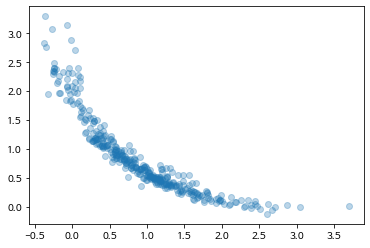

In [5]:
plt.scatter(word_vectors.T[0], word_vectors.T[1], alpha=0.3)
plt.show()

### 차원축소를 하지 않으면 전혀 군집이 되지 않음

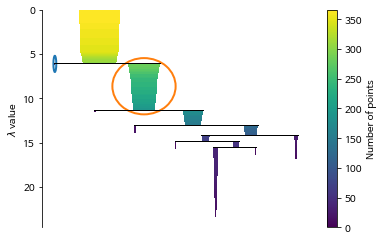

In [6]:
import hdbscan
from sklearn.cluster import DBSCAN

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
clusterer.fit(word_vectors)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [31]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=5).fit(word_vectors)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(word_vectors)

# 데이터 프레임 만들기
df = pd.DataFrame(word_vectors)
df["labels"] = pred_hds
df.index = vocabs

print(np.unique(df["labels"]))
df.tail(2)

[-1  0  1  2  3  4  5  6  7  8  9 10 11]


,0,1,labels
글램핑다,0.567014,1.046619,-1
냉장고,1.321527,0.352015,10


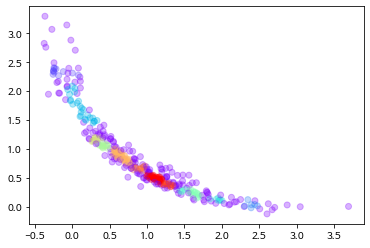

In [32]:
plt.scatter(df[0], df[1], c=df["labels"], cmap="rainbow", alpha=0.3)
plt.show()

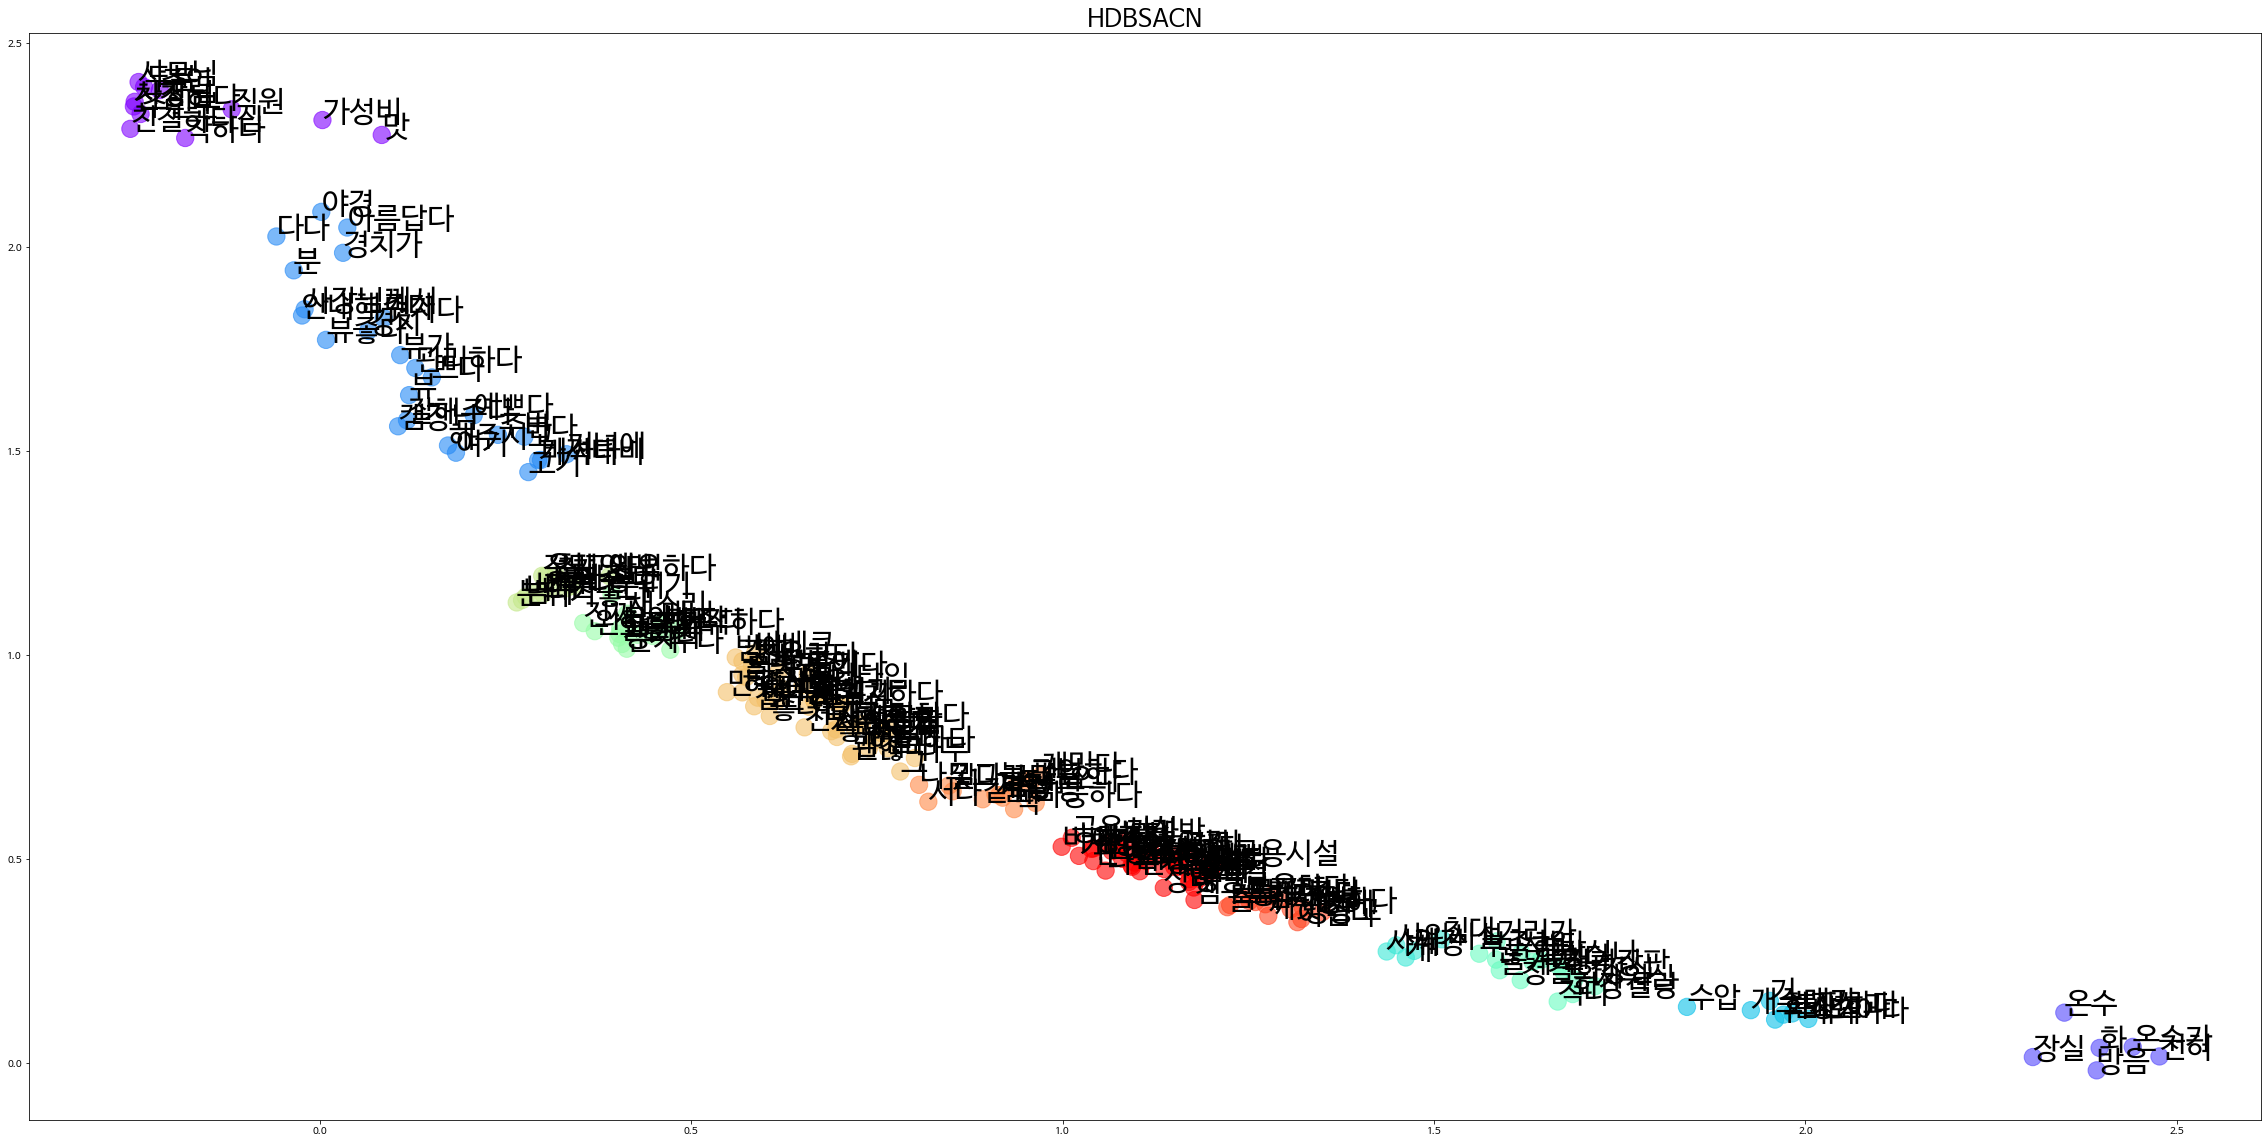

In [35]:
plt.figure(figsize=(40, 20))
plt.title("HDBSACN", fontsize= 25)
df.drop(df[df['labels']== -1].index,inplace=True)
plt.scatter(df[0], df[1], c= df["labels"], s=300, cmap="rainbow", alpha=0.6)

for i, v in enumerate(df.index):
    plt.annotate(v, xy=(df[0][i], df[1][i]), fontsize=30)

plt.show()

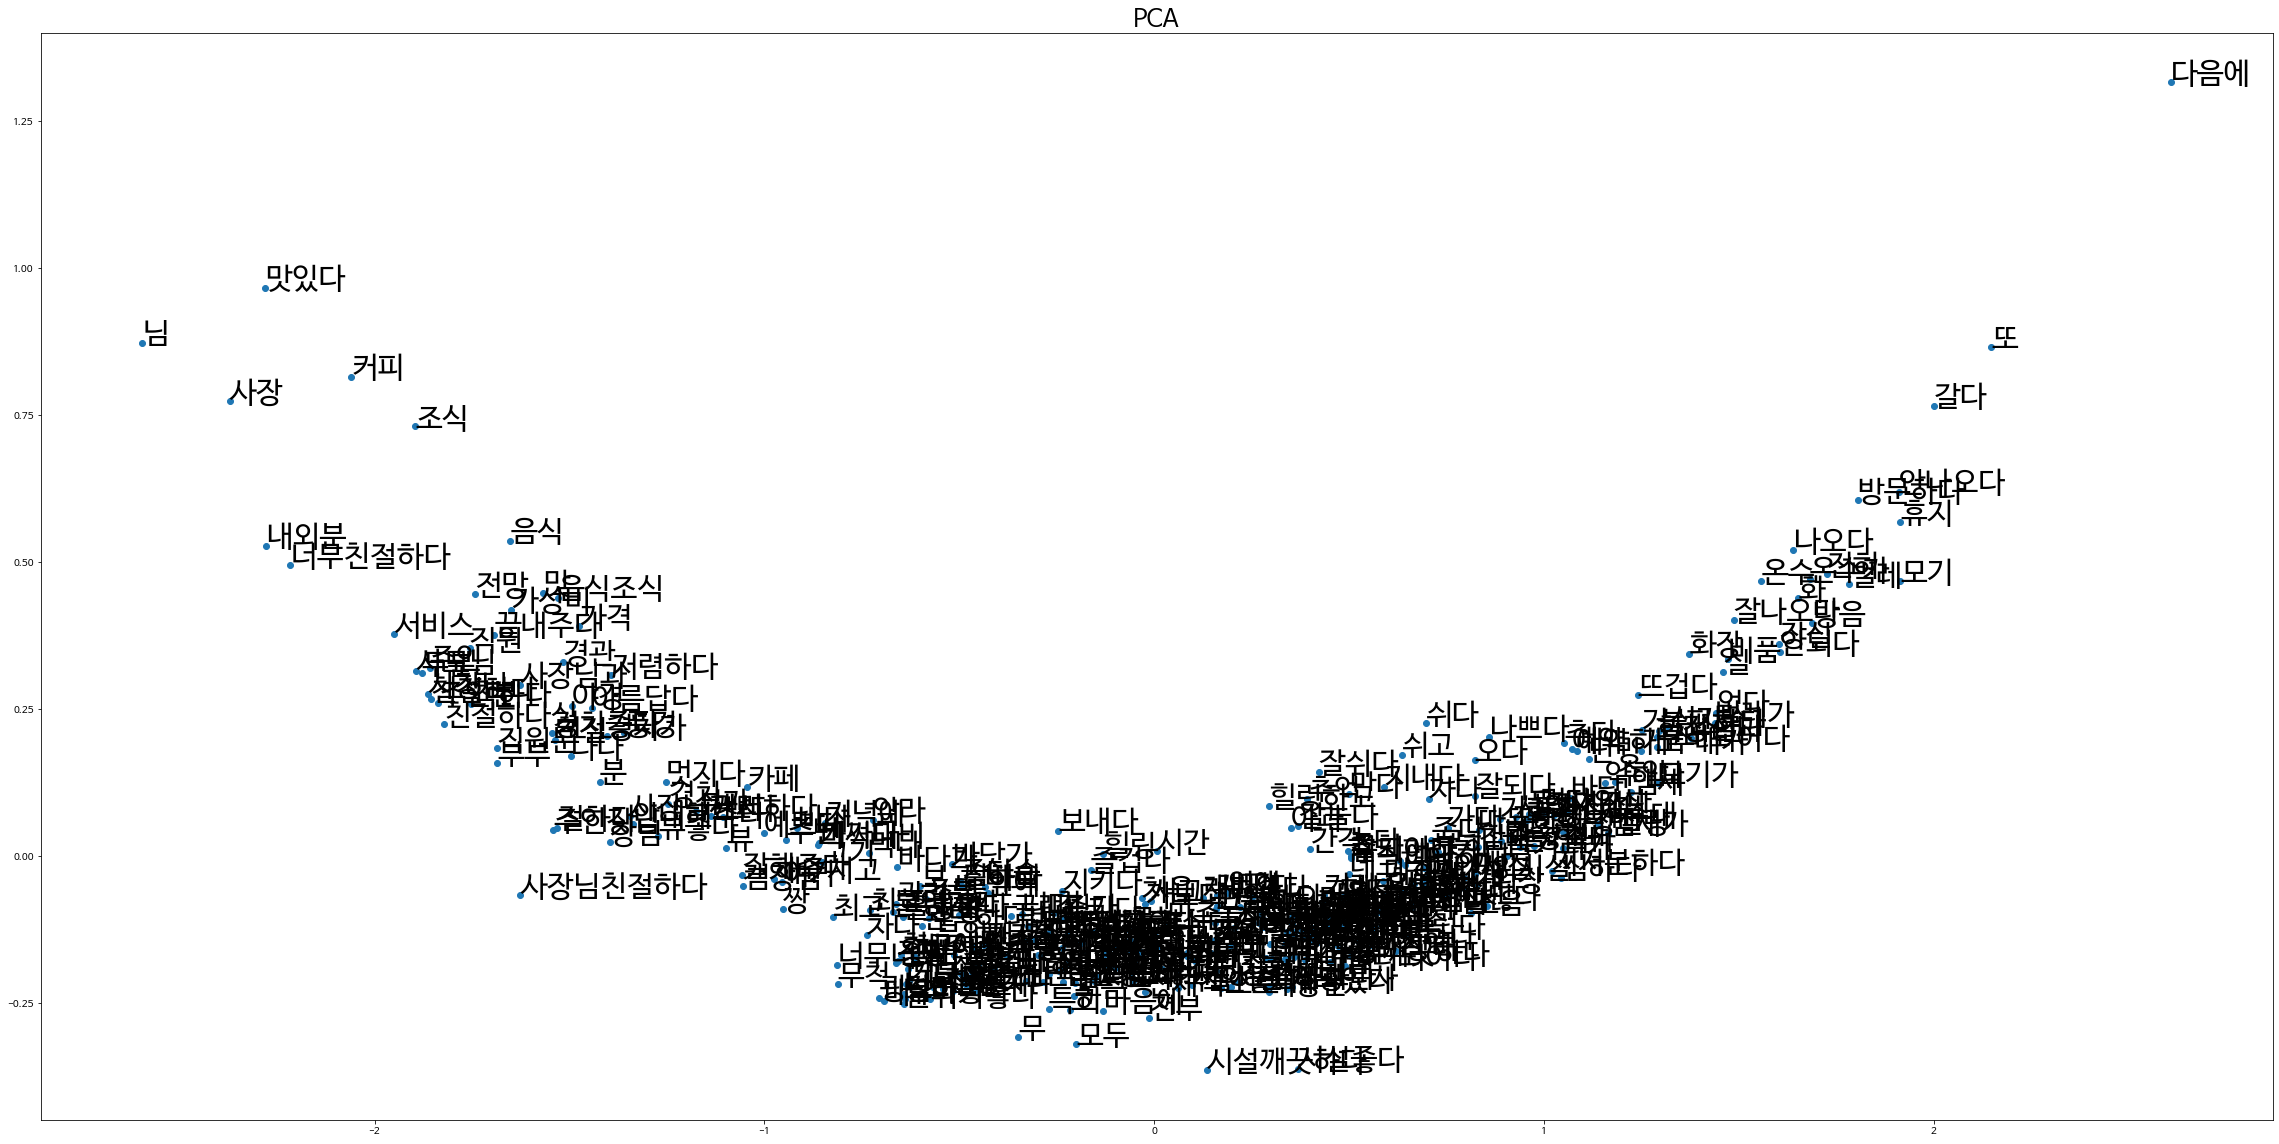

In [36]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(word_vectors)
pca_df = pd.DataFrame(pca_fit, index=vocabs, columns=['x', 'y'])

plt.figure(figsize=(40, 20))
plt.title("PCA", fontsize= 25)
plt.scatter(pca_df["x"], pca_df["y"])

for word, pos in pca_df.iterrows():
    plt.annotate(word, pos, fontsize=30)
plt.show()

#xys = pca.fit_transform(word_vectors)
# xs = xys[:, 0]
# ys = xys[:, 1]

# plt.figure(figsize=(40, 20))
# plt.title("PCA clustering")
# plt.scatter(xs, ys)
# for i, v in enumerate(vocabs):
#     plt.annotate(v, xy=(xs[i], ys[i]), fontsize=30)
# plt.show()

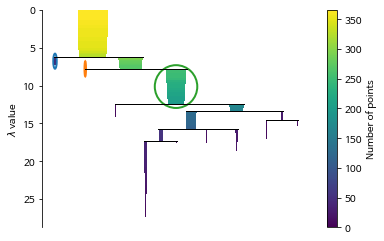

In [37]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, gen_min_span_tree=True)
clusterer.fit(pca_df)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [39]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=5).fit(pca_df)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(pca_df)

# 데이터 프레임 만들기
df2 = pd.DataFrame(pca_df)
df2["labels"] = pred_hds

print(np.unique(df2["labels"]), len(df2))
df2.tail(2)

[-1  0  1  2  3] 366


,x,y,labels
글램핑다,-0.366434,-0.101465,0
냉장고,0.658868,-0.078693,0


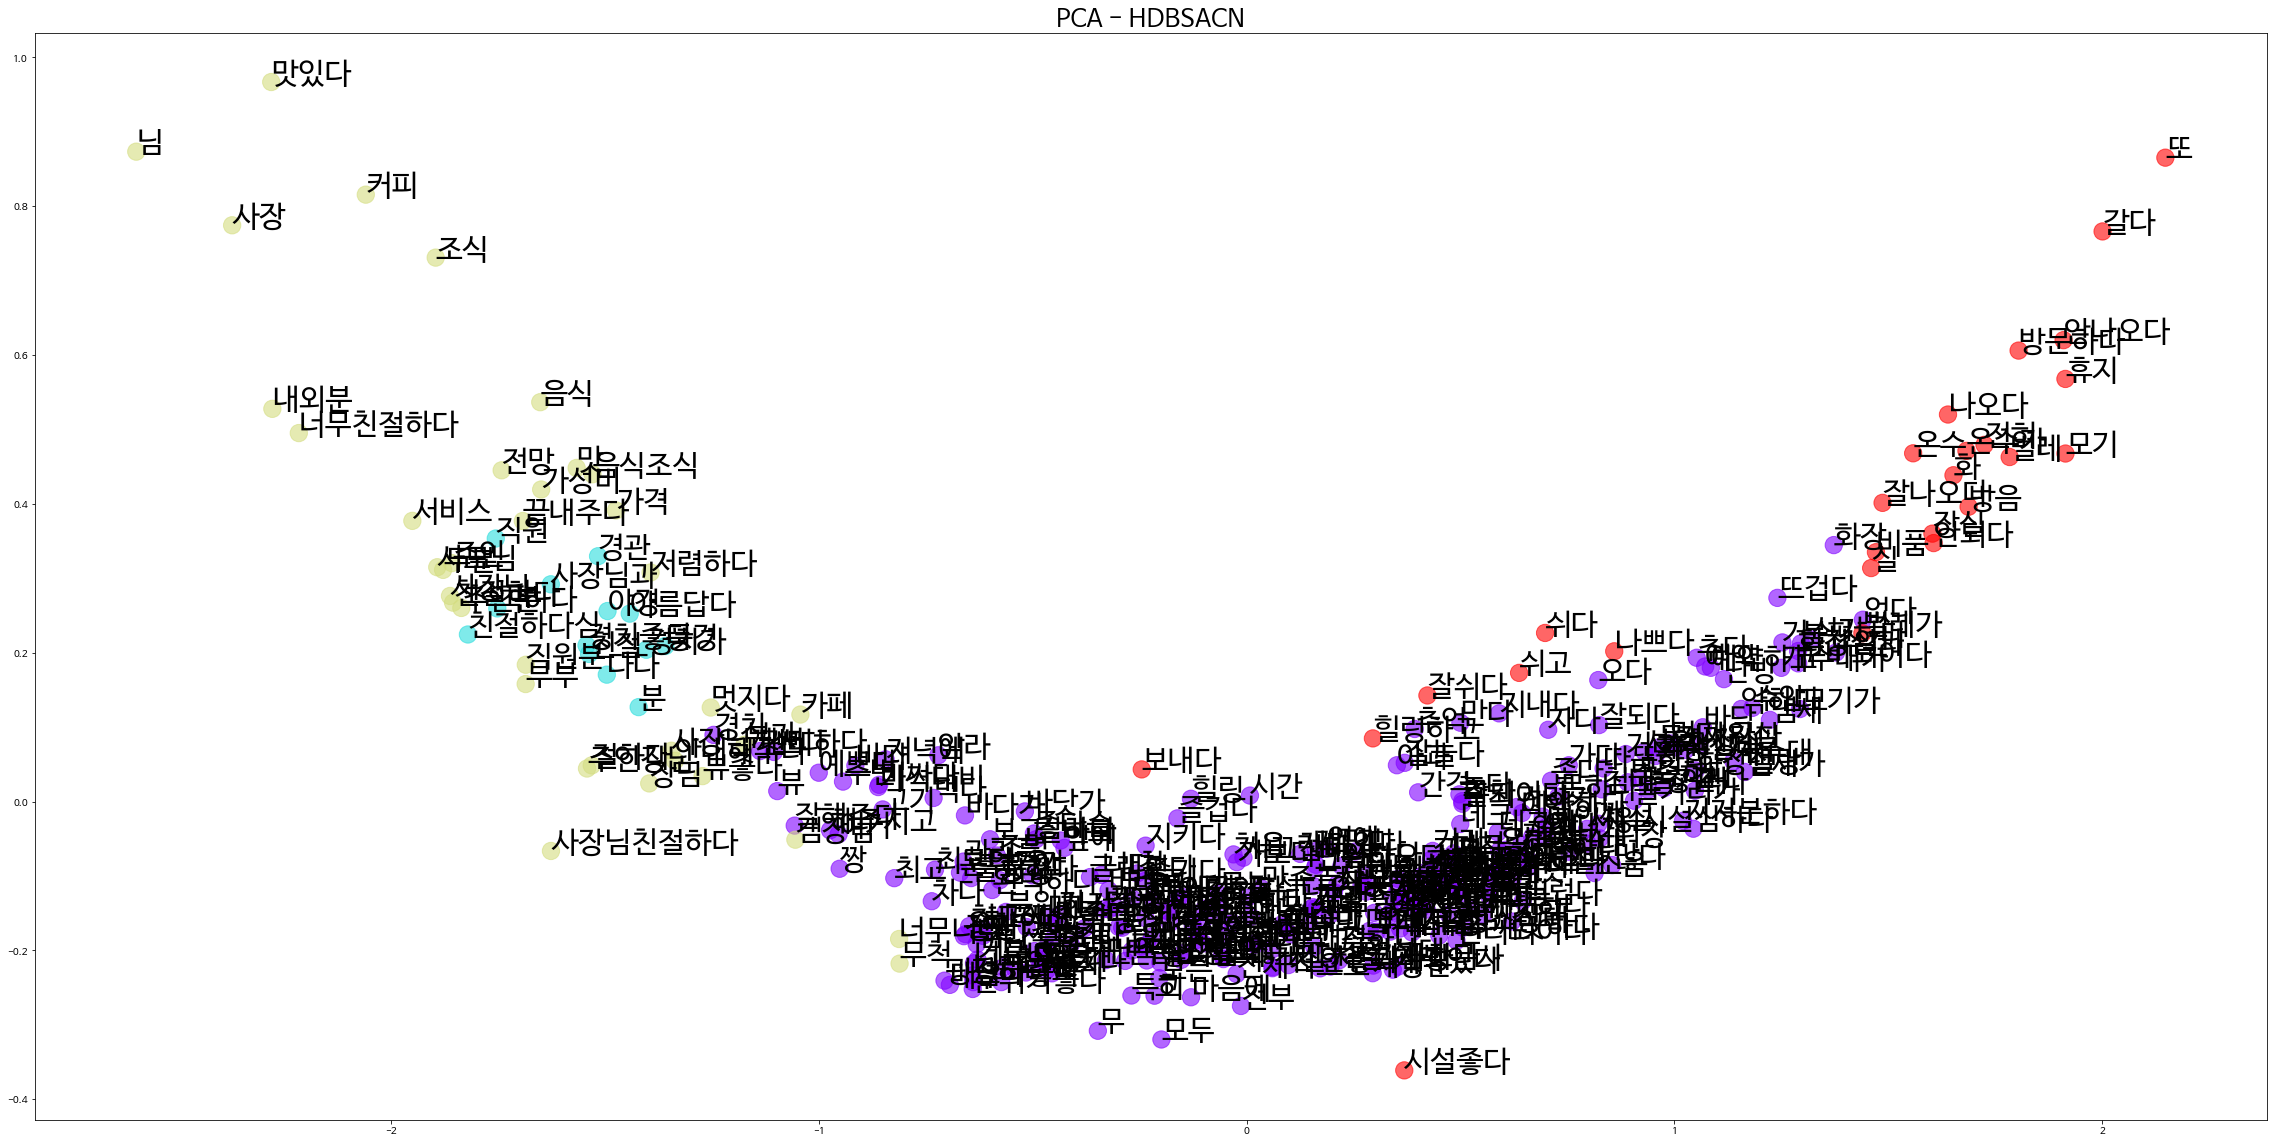

In [40]:
plt.figure(figsize=(40, 20))
plt.title("PCA - HDBSACN", fontsize= 25)
df2.drop(df2[df2['labels']== -1].index,inplace=True)
plt.scatter(df2["x"], df2["y"], c= df2["labels"], s=300, cmap="rainbow", alpha=0.6)
    
for i, v in enumerate(df2.index):
    plt.annotate(v, xy=(df2["x"][i], df2["y"][i]), fontsize=30)

plt.show()

### TSNE 축소법

In [49]:
tsne = TSNE(learning_rate=100)
tsne_fit = tsne.fit_transform(word_vectors)
tsne_df = pd.DataFrame(tsne_fit, index=vocabs, columns=['x', 'y'])

# plt.figure(figsize=(40, 20))
# plt.title("TSNE", fontsize= 25)
# plt.scatter(tsne_df["x"], tsne_df["y"])

# for word, pos in tsne_df.iterrows():
#     plt.annotate(word, pos, fontsize=30)
# plt.show()

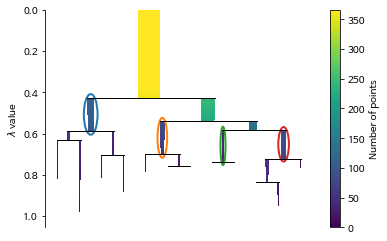

In [42]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, gen_min_span_tree=True)
clusterer.fit(tsne_df)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [51]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=8).fit(tsne_df)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(tsne_df)

# 데이터 프레임 만들기
df3 = pd.DataFrame(tsne_df)
df3["labels"] = pred_hds

print(np.unique(df3["labels"]), len(df3))
df3.tail(2)

[-1  0  1  2  3  4  5] 366


,x,y,labels
글램핑다,5.028105,-13.404472,5
냉장고,-0.447464,19.601547,1


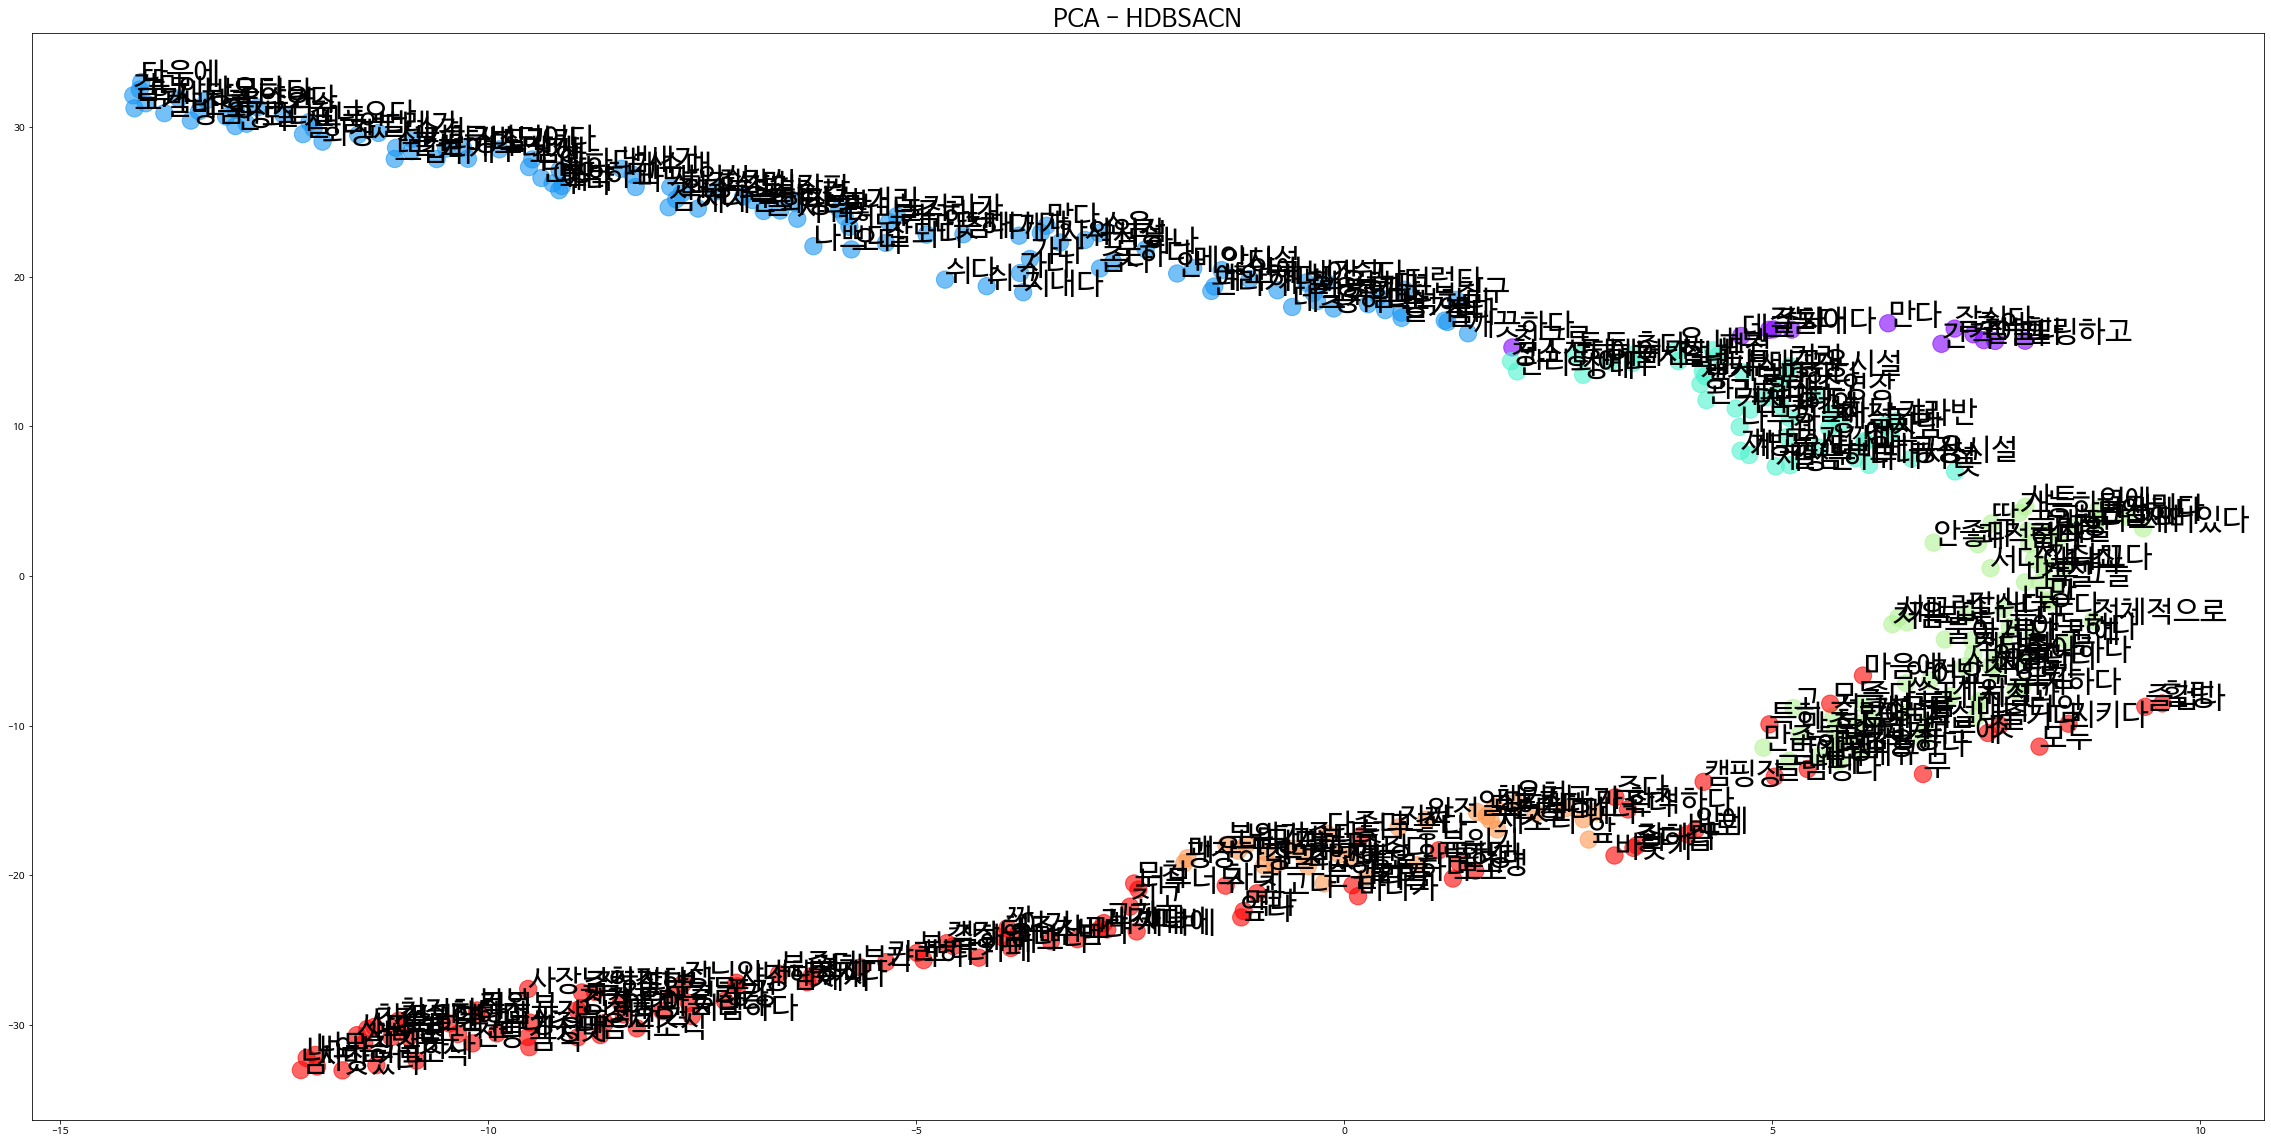

In [52]:
plt.figure(figsize=(40, 20))
plt.title("PCA - HDBSACN", fontsize= 25)
df3.drop(df3[df3['labels']== -1].index,inplace=True)
plt.scatter(df3["x"], df3["y"], c= df3["labels"], s=300, cmap="rainbow", alpha=0.6)
    
for i, v in enumerate(df3.index):
    plt.annotate(v, xy=(df3["x"][i], df3["y"][i]), fontsize=30)

plt.show()